# Parallel and Distributed Systems - HW 3
### Thomas Katsavos
### 2025-26

This notebook was used for testing three different CUDA kernel implementations based on a sequential Label Propagation algorithm using three matrices, performing measurements and extracting some results. The code is written in Julia with CUDA.jl package and runs in Google Colab Julia runtime with a T4 GPU.
When the reader of this file tries to execute the cells again, it is needed to select this specific setup! This file is complementary to the project's report and serves as a ready-to-use environment, code repository and user manual.

# JULIA SETUP
First, after selecting the Julia + T4 runtime, we have to install the packages that we will use. 'MAT' and 'SparseArrays' are used for reading and converting the Matlab sparse matrix to CSR format. 'CUDA' package is the Julia's standard for CUDA kernel syntax and backend execution. 'BenchmarkTools' is used for the needed measurements in time and performance. The first execution of the cell bellow will propably take a few minutes.

### For a correct execution without problems, you have to run all the cells with the order they are contained in this file!

In [1]:
using Pkg
Pkg.add(["MAT", "SparseArrays", "CUDA","BenchmarkTools", "Plots"])
using MAT, CUDA, SparseArrays, BenchmarkTools


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


# MATLAB FILES LOADING
In the cell bellow we download from SuiteSparse website the 3 .mat files we will need, containing matrices in MATLAB CSC format.

In [2]:
if !isfile("com-Orkut.mat")
  run(`wget https://suitesparse-collection-website.herokuapp.com/mat/SNAP/com-Orkut.mat`)
end

if !isfile("com-LiveJournal.mat")
  run(`wget https://suitesparse-collection-website.herokuapp.com/mat/SNAP/com-LiveJournal.mat`)
end

if !isfile("rgg_n_2_23_s0.mat")
  run(`wget https://suitesparse-collection-website.herokuapp.com/mat/DIMACS10/rgg_n_2_23_s0.mat`)
end


# SEQUENTIAL FUNCTION
In the cell bellow we include the sequential function which the parallel CUDA implementations will be based on.

In [3]:
function labelprop_seq!(labels, row_ptr, col_idx, n)
  iters = 0
  chgd = true

  while(chgd)
    iters+=1
    chgd = false

    for v in 1:n
      best = labels[v]
      for e in row_ptr[v]:(row_ptr[v+1]-1)
        u = col_idx[e]
        lu = labels[u]
        if lu<best
          best = lu;
        end
      end
      if(best<labels[v])
        labels[v] = best
        chgd = true
      end

    end
  end
  return iters
end

labelprop_seq! (generic function with 1 method)

# LOADING MATRIX, CONVERSION TO CSR FORMAT AND SEQUENTIAL EXECUTION
Here the MATLAB file (for com-Orcut in this case) is 'read', then converted to CSR and the sequential LP algorithm is executed with '@btime' for strictly measuring the execution time.

In [4]:
file = matopen("com-Orkut.mat")# open .mat file
mat_csc = read(file, "Problem")["A"] #load from disk in csc format
mat_csr = SparseMatrixCSC(mat_csc')#convert to csr

n = length(mat_csr.colptr)-1 #number of non-zeros
println("Sequential execution time for matrix com-Orkut: ")
#sequential execution
@btime labelprop_seq!(collect(1:n), mat_csr.colptr, mat_csr.rowval, n)
#CUDA Arrays for row pointers and columns indices vectors
row_ptr = CuArray(mat_csr.colptr)
col_idx = CuArray(mat_csr.rowval)

m = length(col_idx)

#clear no-more useful elements
mat_csc = nothing
mat_csr = nothing
close(file)

Sequential execution time for matrix com-Orkut: 
  2.637 s (6 allocations: 23.44 MiB)


# CHECK FOR GPU
This script checks for CPU access and compatibility.

In [5]:
# Check if a GPU is available
if CUDA.functional()
    dev = CUDA.device()
    println("Success! Connected to: ", CUDA.name(dev))
    println("VRAM Available: ", CUDA.totalmem(dev) / 1024^3, " GB")
else
    println("GPU not found. Check Colab Runtime settings.")
end

Success! Connected to: Tesla T4
VRAM Available: 14.74127197265625 GB


In the next cell we include four different kernel functions, with the three different approaches that were asked for the project regarding the GPU threads mapping plus one more:
 - CASE 1: Simplistic approach ->assign one thread to work on each vertex(with activation mask)
 - CASE 2: Improved and scalable -> grid-stride loop/thread works on chunks of nodes
 - CASE 3: Better for larger and complicated matrices -> assign a warp to work on each vertex, utilize shared memory (shmem)
 - CASE 4: Our best speedup -> assign a warp to work on each vertex, utilize registers instead of shared memory(with activation mask)

 They will be used with all three of the matrices(com-Orcut, com-LiveJournal, rgg)

In [20]:
###########################################################
#CASE 1
function labelprop_case1_kernel!(labels, row_ptr, col_idx, n, changed, active_curr, active_next, active_counter)
  idx = (blockIdx().x-1) * blockDim().x + threadIdx().x #thread indexing

  if idx <=n && active_curr[idx]#until covering all (active) nodes with a thread
    curr_label = labels[idx]
    new_label = curr_label

    degree = row_ptr[idx+1]- row_ptr[idx]
    CUDA.@atomic active_counter[1]+= degree

    #neighbouring nodes access
    for i in row_ptr[idx]:(row_ptr[idx+1]-1)
      neighbour = col_idx[i]
      new_label = min(new_label, labels[neighbour])
    end
    #label atomic update
    if new_label < curr_label
      CUDA.atomic_min!(pointer(labels, idx), new_label)
      if changed[1]==0 #updating 'changed' variable, atomic oper.
        CUDA.atomic_xchg!(pointer(changed,1), Int32(1))
      end
      #update activation mask
      for i in row_ptr[idx]:(row_ptr[idx+1]-1)
        active_next[col_idx[i]]= true
      end
    end
  end

  return nothing
end


#######################################################
# CASE 2

function labelprop_case2_kernel!(labels, row_ptr, col_idx, n, changed)

  index = (blockIdx().x-1) * blockDim().x + threadIdx().x #thread indexing
  incr = gridDim().x * blockDim().x #define incrementation 'step'

  #utilize enough threads for covering 'chunks'/teams of nodes
  for idx in index:incr:n
    curr_label = labels[idx]
    new_label = curr_label
    #work on neighbors of each node
    for i in row_ptr[idx]:(row_ptr[idx+1]-1)
      neighbour = col_idx[i]
      new_label = min(new_label, labels[neighbour])
    end

    if new_label < curr_label
      CUDA.atomic_min!(pointer(labels, idx), new_label)
      if changed[1]==0
        CUDA.atomic_xchg!(pointer(changed,1), Int32(1))
      end
    end
  end

  return nothing
end

#########################################################
#CASE 3

function labelprop_case3_kernel!(labels, row_ptr, col_idx, n, changed)
    #Shared memory allocation-the size is the number of threads inside a block
    shmem = CuDynamicSharedArray(Int32, blockDim().x)

    threads_per_warp = 32 #define thread-inside-warp count

    #Warp ID definition - div(x,y) -> returns integer part of x/y
    warp_id = div((blockIdx().x - 1) * blockDim().x + threadIdx().x - 1, threads_per_warp) + 1

    #Lane ID - thread identificiation inside a warp
    lane_id = (threadIdx().x - 1) % threads_per_warp + 1

    #Position inside the whole block
    tid = threadIdx().x

    #We use warps until we have 'covered' all nodes
    if warp_id <= n
        row_start = row_ptr[warp_id]
        row_end = row_ptr[warp_id + 1] - 1

        curr_label = labels[warp_id]
        min_label = curr_label  #this is the minimum of each THREAD, a local minimum

        # Every thread inside a warp reads some neighboring vertices/nodes.
        for i in (row_start + lane_id - 1):threads_per_warp:row_end
            neighbor_label = labels[col_idx[i]]
            if neighbor_label < min_label
                min_label = neighbor_label
            end
        end


        # We save every thread-local minimum label inside shared memory
        shmem[tid] = min_label

        #synchronize warps
        CUDA.sync_warp()

        # Compare minimums inside shared memory
        #We start comparing 1-17, 2-18, ...
        #...then we compare the new minimums the same way until one remains!
        offset = 16
        while offset > 0
            if lane_id <= offset
                remote_val = shmem[tid + offset]
                if remote_val < shmem[tid]
                    shmem[tid] = remote_val
                end
            end

            # Syncronize in every iteration for avoiding race conditions
            CUDA.sync_warp()
            offset = div(offset, 2)
        end

        #Thread 1 of warp now has the best label
        if lane_id == 1
            final_min = shmem[tid]
            if final_min < curr_label#update min
                CUDA.atomic_min!(pointer(labels, warp_id), final_min)
                CUDA.atomic_xchg!(pointer(changed, 1), Int32(1))
            end
        end
    end
    return nothing
end

############################################################################
#CASE 4 (EXTRA)

function labelprop_case4_kernel!(labels, row_ptr, col_idx, n, changed, active_curr, active_next, active_counter)
    threads_per_warp = 32

    #Position inside the whole block
    tid = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    #Lane ID - thread identificiation inside a warp
    lane_id = (threadIdx().x - 1) % threads_per_warp + 1
    #Warp ID definition - div(x,y) -> returns integer part of x/y
    warp_id = div(tid - 1, threads_per_warp) + 1

    #activation flag initially false
    node_is_active = false

    if warp_id <= n
        if lane_id == 1
            node_is_active = active_curr[warp_id]
        end
        node_is_active = CUDA.shfl_sync(0xffffffff, node_is_active, 1)

        if node_is_active
            row_start = row_ptr[warp_id]
            row_end_ptr = row_ptr[warp_id + 1]
            row_end = row_end_ptr - 1
            #logic for counting total traversed edges-the active ones for each iter.
            if lane_id == 1
                degree = Int64(row_end_ptr - row_start)
                CUDA.atomic_add!(pointer(active_counter, 1), degree)
            end

            curr_label = labels[warp_id]
            min_label = curr_label

            for i in (row_start + lane_id - 1):threads_per_warp:row_end
                neighbor_idx = col_idx[i]
                if neighbor_idx >= 1 && neighbor_idx <= n
                    neighbor_label = labels[neighbor_idx]
                    if neighbor_label < min_label
                        min_label = neighbor_label
                    end
                end
            end

            # Compare minimums - Warp-Shuffle function
            mask = 0xffffffff
            offset = 16
            while offset > 0
                min_gen = CUDA.shfl_down_sync(mask, min_label, offset)
                if min_gen < min_label
                    min_label = min_gen
                end
                offset = div(offset, 2)
            end
            #Broadcast new min. label
            min_label = CUDA.shfl_sync(mask, min_label, 1)

            if min_label < curr_label
                if lane_id == 1
                    CUDA.atomic_min!(pointer(labels, warp_id), min_label)
                    CUDA.atomic_xchg!(pointer(changed, 1), Int32(1))
                end
                #update activation mask
                for i in (row_start + lane_id - 1):threads_per_warp:row_end
                    neighbor_idx = col_idx[i]
                    if neighbor_idx >= 1 && neighbor_idx <= n
                        active_next[neighbor_idx] = true
                    end
                end
            end
        end
    end
    return nothing
end

labelprop_case4_kernel! (generic function with 1 method)

# KERNEL EXECUTION FUNCTIONS
We use functions to execute the kernels for the 3 matrices for these reasons:
- Repeatability
- Pre-compilation utilizing Julia's JIT property, making recorded execution durations more uniform

In [21]:
#######################################################
# Function for running CASE 1 method
function exec_kernel1(matname, n, m, row_ptr, col_idx)
  labels = CuArray{Int32}(1:n)
  changed = CuArray(Int32[0])

  active_curr = CUDA.ones(Bool,n)
  active_next = CUDA.zeros(Bool,n)

  active_counter = CuArray(Int64[0])
  edges_accessed = 0

  println("Starting compilation...")

  kernel = @cuda launch=false labelprop_case1_kernel!(labels, row_ptr, col_idx, n, changed, active_curr, active_next, active_counter)

  config = launch_configuration(kernel.fun)
  threads = config.threads
  blocks = cld(n, threads)

  println("Running LP/CC on $matname on Tesla T4 GPU...")

  iterations =0
  time_dur = CUDA.@elapsed begin

    while true
      CUDA.fill!(changed,0)
      CUDA.fill!(active_next,false)

      kernel(labels, row_ptr, col_idx, n, changed, active_curr, active_next, active_counter; threads=threads, blocks=blocks)

     iterations +=1

      if CUDA.@allowscalar(changed[1]) == 0
        break
      end

      active_curr,active_next = active_next, active_curr
    end
  end
  #actual number of traversed edges
  edges_accessed = CUDA.@allowscalar(active_counter[1])

  println("Case 1 Converged!")
  sccs = length(unique(Array(labels)))
  println("Converged after $iterations iterations, time needed: $time_dur seconds. Graph $matname has $sccs SCCs")

  bytes_tot = (
   n * iterations * sizeof(Bool) +
   edges_accessed* sizeof(eltype(col_idx)) +
   edges_accessed* sizeof(eltype(labels)) +  #neighbour search
   n*iterations* sizeof(eltype(labels))  #present node's read-write
  )

  bytes_p_iter = bytes_tot/iterations

  return iterations, time_dur, bytes_p_iter, edges_accessed

end

#######################################################
# Function for running CASE 2 method


function exec_kernel2(matname, n, m, row_ptr, col_idx)
  labels = CuArray{Int32}(1:n)
  changed = CuArray(Int32[0])

  println("Starting compilation...")

  kernel = @cuda launch=false labelprop_case2_kernel!(labels, row_ptr, col_idx, n, changed)

  config = launch_configuration(kernel.fun)
  threads = config.threads
  blocks = cld(n, threads)

  println("Running LP/CC on $matname on Tesla T4 GPU...")

  iterations =0
  time_dur = CUDA.@elapsed begin

    while true
      CUDA.fill!(changed,0)
      kernel(labels, row_ptr, col_idx, n, changed, threads=threads, blocks=blocks)

      iterations +=1
      if CUDA.@allowscalar(changed[1]) == 0
        break
      end
    end
  end

  println("Case 2 Converged!")
  sccs = length(unique(Array(labels)))
  println("Converged after $iterations iterations, time needed: $time_dur seconds. Graph $matname has $sccs SCCs")

  bytes_p_iter = (
   (n+1)* sizeof(eltype(row_ptr)) +
   m* sizeof(eltype(col_idx)) +
   m* sizeof(eltype(labels)) +  #neighbour search
   n*2* sizeof(eltype(labels))  #present node's read-write
  )

  return iterations, time_dur, bytes_p_iter

end

#######################################################
# Function for running CASE 3 method

function exec_kernel3(matname, n, m, row_ptr, col_idx)
  labels = CuArray{Int32}(1:n)
  changed = CuArray(Int32[0])

  println("Starting compilation...")

  threads_per_block = 256
  warps_per_block = div(threads_per_block, 32)
  num_blocks = div(n + warps_per_block - 1, warps_per_block)
  shmem_size = threads_per_block * sizeof(Int32)

  kernel = @cuda launch=false labelprop_case3_kernel!(labels, row_ptr, col_idx, n, changed)


  println("Running LP/CC on $matname on Tesla T4 GPU...")

  iterations =0
  time_dur = CUDA.@elapsed begin

   while true
     CUDA.fill!(changed,0)

     kernel(
      labels, row_ptr, col_idx, n, changed;
      threads=threads_per_block,
      blocks=num_blocks,
      shmem=shmem_size
     )

     iterations +=1

     if CUDA.@allowscalar(changed[1]) == 0
        break
      end
    end
  end

  println("Case 3 Converged!")
  sccs = length(unique(Array(labels)))
  println("Converged after $iterations iterations, time needed: $time_dur seconds. Graph $matname has $sccs SCCs")

  bytes_p_iter = (
    (n+1)* sizeof(eltype(row_ptr)) +
    m* sizeof(eltype(col_idx)) +
    m* sizeof(eltype(labels)) +  #neighbour search
    n*2* sizeof(eltype(labels))  #present node's read-write
  )

  return iterations, time_dur, bytes_p_iter

end

#######################################################
# Function for running CASE 4 method

function exec_kernel4(matname, n, m, row_ptr, col_idx)

  # CUDA Arrays fro labels vector and 'changed' flag variable
  labels = CuArray{Int32}(1:n)
  changed = CuArray(Int32[0])

  active_counter = CuArray(Int64[0])
  edges_accessed = 0

  active_curr = CUDA.ones(Bool, n)
  active_next = CUDA.zeros(Bool, n)

  println("Starting compilation...")

  threads_per_block = 256
  warps_per_block = div(threads_per_block, 32)
  num_blocks = div(n + warps_per_block - 1, warps_per_block)


  kernel = @cuda launch=false labelprop_case4_kernel!(labels, row_ptr, col_idx, n, changed, active_curr, active_next, active_counter)
  println("Running LP/CC on $matname on Tesla T4 GPU...")

  iterations =0
  time_dur = CUDA.@elapsed begin

    while true
      CUDA.fill!(changed,0)
      CUDA.fill!(active_next, false)

      kernel(
    labels, row_ptr, col_idx, n, changed, active_curr, active_next, active_counter;
    threads=threads_per_block,
    blocks=num_blocks
   )

      iterations +=1

      if CUDA.@allowscalar(changed[1]) == 0
        break
      end

      active_curr, active_next = active_next, active_curr
   end
  end

  edges_accessed = CUDA.@allowscalar(active_counter[1])

  println("Case 4 Converged!")
  sccs = length(unique(Array(labels)))
  println("Converged after $iterations iterations, time needed: $time_dur seconds. Graph $matname has $sccs SCCs")

  bytes_tot = (
   n * iterations * sizeof(Bool) +
   edges_accessed* sizeof(eltype(col_idx)) +
   edges_accessed* sizeof(eltype(labels)) +  #neighbour search
   n*iterations* sizeof(eltype(labels))  #present node's read-write
  )

  bytes_p_iter = bytes_tot/iterations

  return iterations, time_dur, bytes_p_iter, edges_accessed
end

exec_kernel4 (generic function with 1 method)

# CASE 1 - com-Orkut
Executing LP-CC on com-Orkut using Case 1 kernel


In [22]:
iterations,time_dur, bytes_p_iter, edges_accessed = exec_kernel1("com-Orcut", n, m, row_ptr, col_idx)


tot_bytes = bytes_p_iter*iterations
max_bw = 320
bw_eff = (tot_bytes/time_dur)/1e9
gteps = (edges_accessed) / (time_dur * 1e9)

println("Iterations needed: $iterations")
println("Data transport during execution: $(round(tot_bytes/1e9, digits=3)) GB")
println("Effective bandwidth:  $(round(bw_eff, digits=3)) GB/s")
println("BW Efficiency: $(round(bw_eff/max_bw*100, digits=3))%")
println("Throughput: $(round(gteps, digits=3)) GTEPS")

Starting compilation...
Running LP/CC on com-Orcut on Tesla T4 GPU...
Case 1 Converged!
Converged after 5 iterations, time needed: 0.4941966 seconds. Graph com-Orcut has 1 SCCs
Iterations needed: 5
Data transport during execution: 10.706 GB
Effective bandwidth:  21.664 GB/s
BW Efficiency: 6.77%
Throughput: 1.792 GTEPS


# CASE 2 - com-Orkut
Executing LP-CC on com-Orkut using Case 2 kernel

In [23]:
iterations,time_dur, bytes_p_iter = exec_kernel2("com-Orkut", n, m, row_ptr, col_idx)


tot_bytes = bytes_p_iter*iterations
max_bw = 320
bw_eff = (tot_bytes/time_dur)/1e9
gteps = (m*iterations) / (time_dur * 1e9)

println("Iterations needed: $iterations")
println("Data transport during execution: $(round(tot_bytes/1e9, digits=3)) GB")
println("Effective bandwidth:  $(round(bw_eff, digits=3)) GB/s")
println("BW Efficiency: $(round(bw_eff/max_bw*100, digits=3))%")
println("Throughput: $(round(gteps, digits=3)) GTEPS")

Starting compilation...
Running LP/CC on com-Orkut on Tesla T4 GPU...
Case 2 Converged!
Converged after 5 iterations, time needed: 0.41388962 seconds. Graph com-Orkut has 1 SCCs
Iterations needed: 5
Data transport during execution: 14.308 GB
Effective bandwidth:  34.57 GB/s
BW Efficiency: 10.803%
Throughput: 2.831 GTEPS


# CASE 3 - com-Orkut
Executing LP-CC on com-Orkut using Case 3 kernel

In [24]:
iterations,time_dur, bytes_p_iter = exec_kernel3("com-Orkut", n, m, row_ptr, col_idx)


tot_bytes = bytes_p_iter*iterations
max_bw = 320
bw_eff = (tot_bytes/time_dur)/1e9
gteps = (m*iterations) / (time_dur * 1e9)

println("Iterations needed: $iterations")
println("Data transport during execution: $(round(tot_bytes/1e9, digits=3)) GB")
println("Effective bandwidth:  $(round(bw_eff, digits=3)) GB/s")
println("BW Efficiency: $(round(bw_eff/max_bw*100, digits=3))%")
println("Throughput: $(round(gteps, digits=3)) GTEPS")

Starting compilation...
Running LP/CC on com-Orkut on Tesla T4 GPU...
Case 3 Converged!
Converged after 4 iterations, time needed: 0.14769165 seconds. Graph com-Orkut has 1 SCCs
Iterations needed: 4
Data transport during execution: 11.446 GB
Effective bandwidth:  77.502 GB/s
BW Efficiency: 24.219%
Throughput: 6.348 GTEPS


# CASE 4 - com-Orkut
Executing LP-CC on com-Orkut using Case 4 kernel

In [25]:
iterations,time_dur, bytes_p_iter, edges_accessed = exec_kernel4("com-Orkut", n, m, row_ptr, col_idx)


tot_bytes = bytes_p_iter*iterations
max_bw = 320
bw_eff = (tot_bytes/time_dur)/1e9
gteps = (edges_accessed) / (time_dur * 1e9)

println("Iterations needed: $iterations")
println("Data transport during execution: $(round(tot_bytes/1e9, digits=3)) GB")
println("Effective bandwidth:  $(round(bw_eff, digits=3)) GB/s")
println("BW Efficiency: $(round(bw_eff/max_bw*100, digits=3))%")
println("Throughput: $(round(gteps, digits=3)) GTEPS")

Starting compilation...
Running LP/CC on com-Orkut on Tesla T4 GPU...
Case 4 Converged!
Converged after 4 iterations, time needed: 0.160803 seconds. Graph com-Orkut has 1 SCCs
Iterations needed: 4
Data transport during execution: 7.844 GB
Effective bandwidth:  48.779 GB/s
BW Efficiency: 15.243%
Throughput: 4.033 GTEPS


# Matrix com-LiveJournal
Here starts the execution using com-LiveJournal matrix. We use the same approaches-steps as before. Run the cell bellow to load and convert 'com-LiveJournal' matrix before running using GPU.

In [43]:
file = matopen("com-LiveJournal.mat")
mat_csc = read(file, "Problem")["A"]
mat_csr = SparseMatrixCSC(mat_csc')

n = length(mat_csr.colptr)-1
println("Sequential execution time for matrix com-LiveJournal: ")
@btime labelprop_seq!(collect(1:n), mat_csr.colptr, mat_csr.rowval, n)

row_ptr = CuArray(mat_csr.colptr)
col_idx = CuArray(mat_csr.rowval)

m = length(col_idx)

mat_csc = nothing
mat_csr = nothing
close(file)

Sequential execution time for matrix com-LiveJournal: 
  2.338 s (6 allocations: 30.50 MiB)


#CASE 1- com-Journal

In [44]:
iterations,time_dur, bytes_p_iter, edges_accessed = exec_kernel1("com-LiveJournal", n, m, row_ptr, col_idx)


tot_bytes = bytes_p_iter*iterations
max_bw = 320
bw_eff = (tot_bytes/time_dur)/1e9
gteps = (edges_accessed) / (time_dur * 1e9)

println("Iterations needed: $iterations")
println("Data transport during execution: $(round(tot_bytes/1e9, digits=3)) GB")
println("Effective bandwidth:  $(round(bw_eff, digits=3)) GB/s")
println("BW Efficiency: $(round(bw_eff/max_bw*100, digits=3))%")
println("Throughput: $(round(gteps, digits=3)) GTEPS")

Starting compilation...
Running LP/CC on com-LiveJournal on Tesla T4 GPU...
Case 1 Converged!
Converged after 9 iterations, time needed: 0.113092706 seconds. Graph com-LiveJournal has 1 SCCs
Iterations needed: 9
Data transport during execution: 2.544 GB
Effective bandwidth:  22.493 GB/s
BW Efficiency: 7.029%
Throughput: 1.742 GTEPS


# CASE 2 - com-LiveJournal

In [46]:
iterations,time_dur, bytes_p_iter = exec_kernel2("com-LiveJournal", n, m, row_ptr, col_idx)


tot_bytes = bytes_p_iter*iterations
max_bw = 320
bw_eff = (tot_bytes/time_dur)/1e9
gteps = (m*iterations) / (time_dur * 1e9)

println("Iterations needed: $iterations")
println("Data transport during execution: $(round(tot_bytes/1e9, digits=3)) GB")
println("Effective bandwidth:  $(round(bw_eff, digits=3)) GB/s")
println("BW Efficiency: $(round(bw_eff/max_bw*100, digits=3))%")
println("Throughput: $(round(gteps, digits=3)) GTEPS")

Starting compilation...
Running LP/CC on com-LiveJournal on Tesla T4 GPU...
Case 2 Converged!
Converged after 9 iterations, time needed: 0.21383256 seconds. Graph com-LiveJournal has 1 SCCs
Iterations needed: 9
Data transport during execution: 8.067 GB
Effective bandwidth:  37.725 GB/s
BW Efficiency: 11.789%
Throughput: 2.919 GTEPS


# CASE 3 - com-LiveJournal

In [47]:
iterations,time_dur, bytes_p_iter = exec_kernel3("com-LiveJournal", n, m, row_ptr, col_idx)


tot_bytes = bytes_p_iter*iterations
max_bw = 320
bw_eff = (tot_bytes/time_dur)/1e9
gteps = (m*iterations) / (time_dur * 1e9)

println("Iterations needed: $iterations")
println("Data transport during execution: $(round(tot_bytes/1e9, digits=3)) GB")
println("Effective bandwidth:  $(round(bw_eff, digits=3)) GB/s")
println("BW Efficiency: $(round(bw_eff/max_bw*100, digits=3))%")
println("Throughput: $(round(gteps, digits=3)) GTEPS")

Starting compilation...
Running LP/CC on com-LiveJournal on Tesla T4 GPU...
Case 3 Converged!
Converged after 9 iterations, time needed: 0.16487148 seconds. Graph com-LiveJournal has 1 SCCs
Iterations needed: 9
Data transport during execution: 8.067 GB
Effective bandwidth:  48.928 GB/s
BW Efficiency: 15.29%
Throughput: 3.786 GTEPS


# CASE 4 - com-LiveJournal

In [48]:
iterations,time_dur, bytes_p_iter, edges_accessed = exec_kernel4("com-LiveJournal", n, m, row_ptr, col_idx)


tot_bytes = bytes_p_iter*iterations
max_bw = 320
bw_eff = (tot_bytes/time_dur)/1e9
gteps = (edges_accessed) / (time_dur * 1e9)

println("Iterations needed: $iterations")
println("Data transport during execution: $(round(tot_bytes/1e9, digits=3)) GB")
println("Effective bandwidth:  $(round(bw_eff, digits=3)) GB/s")
println("BW Efficiency: $(round(bw_eff/max_bw*100, digits=3))%")
println("Throughput: $(round(gteps, digits=3)) GTEPS")

Starting compilation...
Running LP/CC on com-LiveJournal on Tesla T4 GPU...
Case 4 Converged!
Converged after 9 iterations, time needed: 0.086808346 seconds. Graph com-LiveJournal has 1 SCCs
Iterations needed: 9
Data transport during execution: 2.363 GB
Effective bandwidth:  27.225 GB/s
BW Efficiency: 8.508%
Throughput: 2.096 GTEPS


# Matrix rgg
Here starts the execution using rgg matrix. We use the same approaches-steps as before. Run the cell bellow to load and convert 'rgg' matrix before running using GPU.

In [25]:
file = matopen("rgg_n_2_23_s0.mat")
mat_csc = read(file, "Problem")["A"]
mat_csr = SparseMatrixCSC(mat_csc')

n = length(mat_csr.colptr)-1
println("Sequential execution time for matrix rgg: ")
@btime labelprop_seq!(collect(1:n), mat_csr.colptr, mat_csr.rowval, n)

row_ptr = CuArray(mat_csr.colptr)
col_idx = CuArray(mat_csr.rowval)

m = length(col_idx)


mat_csc = nothing
mat_csr = nothing
close(file)

Sequential execution time for matrix rgg: 
  67.193 s (6 allocations: 64.00 MiB)


# CASE 1 - rgg

In [39]:
iterations,time_dur, bytes_p_iter, edges_accessed = exec_kernel1("rgg", n, m, row_ptr, col_idx)


tot_bytes = bytes_p_iter*iterations
max_bw = 320
bw_eff = (tot_bytes/time_dur)/1e9
gteps = (edges_accessed) / (time_dur * 1e9)

println("Iterations needed: $iterations")
println("Data transport during execution: $(round(tot_bytes/1e9, digits=3)) GB")
println("Effective bandwidth:  $(round(bw_eff, digits=3)) GB/s")
println("BW Efficiency: $(round(bw_eff/max_bw*100, digits=3))%")
println("Throughput: $(round(gteps, digits=3)) GTEPS")

Starting compilation...
Running LP/CC on rgg on Tesla T4 GPU...
Case 1 Converged!
Converged after 1871 iterations, time needed: 11.714299 seconds. Graph rgg has 5 SCCs
Iterations needed: 1871
Data transport during execution: 870.379 GB
Effective bandwidth:  74.301 GB/s
BW Efficiency: 23.219%
Throughput: 5.633 GTEPS


# CASE 2 - rgg

In [32]:
iterations,time_dur, bytes_p_iter = exec_kernel2("rgg", n, m, row_ptr, col_idx)


tot_bytes = bytes_p_iter*iterations
max_bw = 320
bw_eff = (tot_bytes/time_dur)/1e9
gteps = (m*iterations) / (time_dur * 1e9)

println("Iterations needed: $iterations")
println("Data transport during execution: $(round(tot_bytes/1e9, digits=3)) GB")
println("Effective bandwidth:  $(round(bw_eff, digits=3)) GB/s")
println("BW Efficiency: $(round(bw_eff/max_bw*100, digits=3))%")
println("Throughput: $(round(gteps, digits=3)) GTEPS")

Starting compilation...
Running LP/CC on rgg on Tesla T4 GPU...
Case 2 Converged!
Converged after 1860 iterations, time needed: 19.64199 seconds. Graph rgg has 5 SCCs
Iterations needed: 1860
Data transport during execution: 3084.347 GB
Effective bandwidth:  157.028 GB/s
BW Efficiency: 49.071%
Throughput: 12.027 GTEPS


# CASE 3 - rgg

In [33]:
iterations,time_dur, bytes_p_iter = exec_kernel3("rgg", n, m, row_ptr, col_idx)


tot_bytes = bytes_p_iter*iterations
max_bw = 320
bw_eff = (tot_bytes/time_dur)/1e9
gteps = (m*iterations) / (time_dur * 1e9)

println("Iterations needed: $iterations")
println("Data transport during execution: $(round(tot_bytes/1e9, digits=3)) GB")
println("Effective bandwidth:  $(round(bw_eff, digits=3)) GB/s")
println("BW Efficiency: $(round(bw_eff/max_bw*100, digits=3))%")
println("Throughput: $(round(gteps, digits=3)) GTEPS")

Starting compilation...
Running LP/CC on rgg on Tesla T4 GPU...
Case 3 Converged!
Converged after 605 iterations, time needed: 11.277976 seconds. Graph rgg has 5 SCCs
Iterations needed: 605
Data transport during execution: 1003.242 GB
Effective bandwidth:  88.956 GB/s
BW Efficiency: 27.799%
Throughput: 6.813 GTEPS


# CASE 4 - rgg

In [36]:
iterations,time_dur, bytes_p_iter, edges_accessed = exec_kernel4("rgg", n, m, row_ptr, col_idx)


tot_bytes = bytes_p_iter*iterations
max_bw = 320
bw_eff = (tot_bytes/time_dur)/1e9
gteps = (edges_accessed) / (time_dur * 1e9)

println("Iterations needed: $iterations")
println("Data transport during execution: $(round(tot_bytes/1e9, digits=3)) GB")
println("Effective bandwidth:  $(round(bw_eff, digits=3)) GB/s")
println("BW Efficiency: $(round(bw_eff/max_bw*100, digits=3))%")
println("Throughput: $(round(gteps, digits=3)) GTEPS")

Starting compilation...
Running LP/CC on rgg on Tesla T4 GPU...
Case 4 Converged!
Converged after 878 iterations, time needed: 4.5895944 seconds. Graph rgg has 5 SCCs
Iterations needed: 878
Data transport during execution: 49.356 GB
Effective bandwidth:  10.754 GB/s
BW Efficiency: 3.361%
Throughput: 0.228 GTEPS


# MEASUREMENTS AND METRICS
During the procedure that followed, the program made some measurements in order to help understand the algorithm's effectiveness and response to GPU parallelisation, scalabiltiy and effects of memory bottlenecks in execution speed. Data collected included:
- Execution time (runtime)
- Iterations count
- Data transported (in GB) during runtime
- GPU Bandwidth utilisation metrics
- Effective Throughput (GTEPS)

In the last cell, we print a plot summarizing the testing results with the average speedup for each matrix in comparison to the sequential CPU execution using different CUDA kernels.

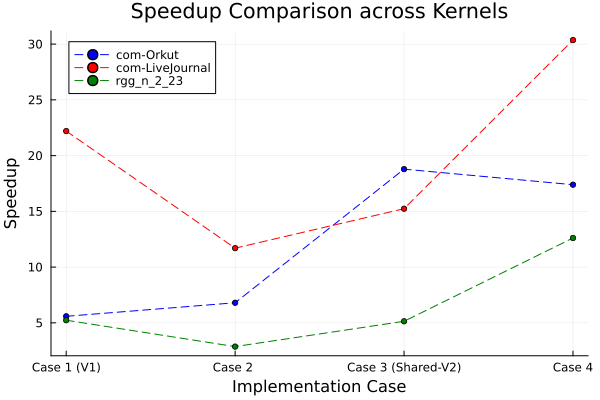

"/content/GPU_Speedup_Results.png"

In [41]:
using Plots
gr()

seq_data = [2.786, 2.502, 55.23]
orkut_data= [0.4988, 0.4097, 0.1483, 0.1602]
livejournal_data = [0.1127, 0.2139, 0.1642, 0.0824]
rgg_data = [10.55, 19.26, 10.75, 4.38]

#calculate speedup
orkut_speedup = seq_data[1] ./ orkut_data
journal_speedup = seq_data[2] ./ livejournal_data
rgg_speedup = seq_data[3] ./ rgg_data

cases = ["Case 1 (V1)", "Case 2 ", "Case 3 (Shared-V2)", "Case 4"]
matrices = ["com-Orkut", "com-LiveJournal", "rgg_n_2_23"]

#create plot
p = plot(
    title = "Speedup Comparison across Kernels",
    xlabel = "Implementation Case",
    ylabel = "Speedup",
    xticks = (1:4, cases),
    legend = :topleft,
    marker = :circle,
    markersize = 6,
    linewidth = 2,
    grid = true
)

plot!(p, 1:4, orkut_speedup, label=matrices[1], color=:blue, markershape=:circle, markersize=:3, linestyle=:dash)
plot!(p, 1:4, journal_speedup, label=matrices[2], color=:red, markershape=:circle, markersize=:3, linestyle=:dash)
plot!(p, 1:4, rgg_speedup, label=matrices[3], color=:green, markershape=:circle, markersize=:3, linestyle=:dash)


display(p)

savefig("GPU_Speedup_Results.png")

# THE END